In [ ]:
!pip install insightface
!pip install onnxruntime
!pip install torch torchvision
!pip install opencv-python
!pip install scikit-learn
!pip install matplotlib pandas

In [ ]:
# Face Recognition: Transfer Learning + LwF (Joint Training DISABLED)
# Clean implementation to isolate LwF contribution

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import cv2
import time
import pickle
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import insightface
from insightface.app import FaceAnalysis
import warnings
import copy
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class KnowledgeDistillationLoss(nn.Module):
    """Knowledge Distillation Loss for Learning without Forgetting"""

    def __init__(self, temperature=3.0, alpha=0.5):
        super(KnowledgeDistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, labels, is_old_class_mask=None):
        """Compute combined loss for new task learning and knowledge preservation"""
        # Standard classification loss
        classification_loss = self.ce_loss(student_logits, labels)

        if teacher_logits is not None and teacher_logits.size(1) > 0:
            # Knowledge distillation loss for old classes
            num_old_classes = teacher_logits.size(1)
            student_old_logits = student_logits[:, :num_old_classes]

            # Soft targets
            soft_student = F.log_softmax(student_old_logits / self.temperature, dim=1)
            soft_teacher = F.softmax(teacher_logits / self.temperature, dim=1)

            distillation_loss = self.kl_loss(soft_student, soft_teacher) * (self.temperature ** 2)

            # Combine losses
            total_loss = (1 - self.alpha) * classification_loss + self.alpha * distillation_loss

            return total_loss, classification_loss, distillation_loss
        else:
            # First task - only classification loss
            return classification_loss, classification_loss, torch.tensor(0.0)

class MobileFaceNetLwF(nn.Module):
    """Transfer learning + LwF wrapper for MobileFaceNet"""

    def __init__(self, num_classes):
        super(MobileFaceNetLwF, self).__init__()

        # Initialize InsightFace model for feature extraction
        self.app = FaceAnalysis(providers=['CPUExecutionProvider'])
        self.app.prepare(ctx_id=0, det_size=(640, 640))

        # Feature and classifier dimensions
        self.feature_dim = 512  # InsightFace feature dimension
        self.num_old_classes = 0

        # Classifier network (using LayerNorm instead of BatchNorm to avoid batch size issues)
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.LayerNorm(256),  # Changed from BatchNorm1d to LayerNorm
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # Store teacher model for knowledge distillation
        self.teacher_model = None

    def forward(self, x):
        """Forward pass through the classifier"""
        return self.classifier(x)

    def get_teacher_outputs(self, x):
        """Get outputs from teacher model for knowledge distillation"""
        if self.teacher_model is not None:
            with torch.no_grad():
                teacher_features = self.teacher_model.classifier[:-1](x)
                teacher_logits = self.teacher_model.classifier[-1](teacher_features)
                return teacher_logits
        return None

    def update_for_new_task(self, num_new_classes):
        """Update model for new task while preserving old knowledge"""
        # Store current model as teacher for next task
        if self.num_old_classes > 0:
            self.teacher_model = copy.deepcopy(self)
            self.teacher_model.eval()
            # Freeze teacher model
            for param in self.teacher_model.parameters():
                param.requires_grad = False

        # Update number of old classes
        self.num_old_classes = self.classifier[-1].out_features
        total_classes = self.num_old_classes + num_new_classes

        # Expand classifier for new classes
        old_weight = self.classifier[-1].weight.data
        old_bias = self.classifier[-1].bias.data

        # Create new final layer
        new_final_layer = nn.Linear(256, total_classes)

        # Copy old weights to preserve knowledge
        with torch.no_grad():
            new_final_layer.weight[:self.num_old_classes] = old_weight
            new_final_layer.bias[:self.num_old_classes] = old_bias

            # Initialize new class weights
            nn.init.kaiming_normal_(new_final_layer.weight[self.num_old_classes:])
            nn.init.constant_(new_final_layer.bias[self.num_old_classes:], 0)

        # Replace final layer
        self.classifier[-1] = new_final_layer

class FaceRecognitionLwFResearcher:
    """Research class implementing Transfer Learning + LwF (Joint Training DISABLED)"""

    def __init__(self, dataset_path, batch_size=5, lwf_temperature=3.0, lwf_alpha=0.5):
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.lwf_temperature = lwf_temperature
        self.lwf_alpha = lwf_alpha

        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # LwF components
        self.kd_loss = KnowledgeDistillationLoss(temperature=lwf_temperature, alpha=lwf_alpha)

        # Data organization
        self.person_folders = []
        self.trained_persons = []
        self.test_data = {}

        # Performance tracking
        self.metrics_history = []
        self.loss_history = []

        print(f"Device: {self.device}")
        print(f"LwF Config - Temperature: {lwf_temperature}, Alpha: {lwf_alpha}")
        print("Joint Training: DISABLED")

    def organize_dataset(self):
        """Organize dataset into person folders"""
        self.person_folders = [f for f in os.listdir(self.dataset_path)
                              if os.path.isdir(os.path.join(self.dataset_path, f))]
        self.person_folders.sort()
        print(f"Found {len(self.person_folders)} person folders")

        # Prepare test data (1 image per person for testing)
        for person in self.person_folders:
            person_path = os.path.join(self.dataset_path, person)
            images = [f for f in os.listdir(person_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            if len(images) > 1:
                test_img = random.choice(images)
                train_imgs = [img for img in images if img != test_img]

                self.test_data[person] = {
                    'test_image': os.path.join(person_path, test_img),
                    'train_images': [os.path.join(person_path, img) for img in train_imgs]
                }

    def extract_features_batch(self, image_paths):
        """Extract features for a batch of images"""
        features = []
        app = FaceAnalysis(providers=['CPUExecutionProvider'])
        app.prepare(ctx_id=0, det_size=(640, 640))

        for img_path in image_paths:
            img = cv2.imread(img_path)
            faces = app.get(img)

            if len(faces) > 0:
                face = max(faces, key=lambda x: x.bbox[2] * x.bbox[3])
                features.append(face.embedding)
            else:
                features.append(np.zeros(512))

        return np.array(features)

    def prepare_training_data_lwf_only(self, current_batch_persons, previous_persons):
        """Prepare training data - JOINT TRAINING DISABLED"""
        # Only use current batch data (no previous batch data)
        current_images = []
        current_labels = []

        for i, person in enumerate(current_batch_persons):
            person_images = self.test_data[person]['train_images']
            current_images.extend(person_images)
            current_labels.extend([len(previous_persons) + i] * len(person_images))

        # All samples are new classes (no old class data)
        old_class_mask = [False] * len(current_images)

        print(f"JOINT TRAINING DISABLED: Using {len(current_images)} new class images only")

        return current_images, current_labels, old_class_mask

    def train_batch_lwf_only(self, batch_persons, is_first_batch=True):
        """Train model using Transfer Learning + LwF only"""
        print(f"\nTraining batch with LwF ONLY: {batch_persons}")

        start_time = time.time()

        # Prepare training data (no joint training)
        if is_first_batch:
            train_images, train_labels, old_class_mask = self.prepare_training_data_lwf_only(
                batch_persons, [])
            num_classes = len(batch_persons)
        else:
            train_images, train_labels, old_class_mask = self.prepare_training_data_lwf_only(
                batch_persons, self.trained_persons)
            num_classes = len(self.trained_persons) + len(batch_persons)

        # Extract features
        print("Extracting features...")
        features = self.extract_features_batch(train_images)

        # Convert to tensors
        features_tensor = torch.FloatTensor(features).to(self.device)
        labels_tensor = torch.LongTensor(train_labels).to(self.device)
        old_class_mask_tensor = torch.BoolTensor(old_class_mask).to(self.device)

        # Initialize or update model
        if is_first_batch:
            self.model = MobileFaceNetLwF(num_classes)
            print("First batch: Created new model")
        else:
            print(f"Expanding model from {self.model.num_old_classes} to {num_classes} classes")
            self.model.update_for_new_task(len(batch_persons))
            print("Teacher model created for LwF")

        self.model.to(self.device)

        # Training setup with adjusted batch size to avoid BatchNorm issues
        optimizer = optim.Adam(self.model.classifier.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        # Create data loader with minimum batch size of 2 to avoid BatchNorm issues
        effective_batch_size = max(2, min(32, len(features_tensor)))
        dataset = torch.utils.data.TensorDataset(features_tensor, labels_tensor, old_class_mask_tensor)
        dataloader = DataLoader(dataset, batch_size=effective_batch_size, shuffle=True, drop_last=False)

        print(f"Using batch size: {effective_batch_size} for {len(features_tensor)} samples")

        # Training loop with LwF
        self.model.train()
        epoch_losses = []

        # Handle case where we have very few samples
        if len(features_tensor) < effective_batch_size:
            print(f"Warning: Only {len(features_tensor)} samples available. Using single-sample training mode.")
            # Switch to evaluation mode for normalization layers during training with small batches
            self.model.eval()

            for epoch in range(15):  # Fewer epochs for single-sample mode
                total_loss = 0
                total_cls_loss = 0
                total_kd_loss = 0

                # Process each sample individually
                for i in range(len(features_tensor)):
                    sample_features = features_tensor[i:i+1]
                    sample_labels = labels_tensor[i:i+1]
                    sample_old_mask = old_class_mask_tensor[i:i+1]

                    optimizer.zero_grad()

                    # Forward pass
                    student_logits = self.model(sample_features)

                    # Get teacher outputs for LwF
                    teacher_logits = None
                    if not is_first_batch and self.model.teacher_model is not None:
                        teacher_logits = self.model.get_teacher_outputs(sample_features)

                    # Compute LwF loss
                    if teacher_logits is not None:
                        total_loss_batch, cls_loss, kd_loss = self.kd_loss(
                            student_logits, teacher_logits, sample_labels, sample_old_mask)
                    else:
                        total_loss_batch, cls_loss, kd_loss = self.kd_loss(
                            student_logits, None, sample_labels, None)

                    # Backward pass
                    total_loss_batch.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    optimizer.step()

                    # Accumulate losses
                    total_loss += total_loss_batch.item()
                    total_cls_loss += cls_loss.item()
                    total_kd_loss += kd_loss.item() if isinstance(kd_loss, torch.Tensor) else kd_loss

                scheduler.step()

                # Record epoch losses
                num_samples = len(features_tensor)
                avg_total_loss = total_loss / num_samples
                avg_cls_loss = total_cls_loss / num_samples
                avg_kd_loss = total_kd_loss / num_samples

                epoch_losses.append({
                    'epoch': epoch + 1,
                    'total_loss': avg_total_loss,
                    'classification_loss': avg_cls_loss,
                    'knowledge_distillation_loss': avg_kd_loss
                })

                if (epoch + 1) % 5 == 0:
                    print(f"Epoch {epoch+1} (single-sample): Total={avg_total_loss:.4f}, Cls={avg_cls_loss:.4f}, KD={avg_kd_loss:.4f}")

        else:
            # Normal batch training mode
            for epoch in range(25):
                total_loss = 0
                total_cls_loss = 0
                total_kd_loss = 0
                num_batches = 0

                for batch_features, batch_labels, batch_old_mask in dataloader:
                    # Skip if batch size is 1 to avoid normalization issues
                    if batch_features.size(0) == 1:
                        continue

                    optimizer.zero_grad()

                    # Forward pass
                    student_logits = self.model(batch_features)

                    # Get teacher outputs for LwF
                    teacher_logits = None
                    if not is_first_batch and self.model.teacher_model is not None:
                        teacher_logits = self.model.get_teacher_outputs(batch_features)

                    # Compute LwF loss
                    if teacher_logits is not None:
                        total_loss_batch, cls_loss, kd_loss = self.kd_loss(
                            student_logits, teacher_logits, batch_labels, batch_old_mask)
                    else:
                        total_loss_batch, cls_loss, kd_loss = self.kd_loss(
                            student_logits, None, batch_labels, None)

                    # Backward pass
                    total_loss_batch.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    optimizer.step()

                    # Accumulate losses
                    total_loss += total_loss_batch.item()
                    total_cls_loss += cls_loss.item()
                    total_kd_loss += kd_loss.item() if isinstance(kd_loss, torch.Tensor) else kd_loss
                    num_batches += 1

                scheduler.step()

                # Record epoch losses (avoid division by zero)
                if num_batches > 0:
                    avg_total_loss = total_loss / num_batches
                    avg_cls_loss = total_cls_loss / num_batches
                    avg_kd_loss = total_kd_loss / num_batches
                else:
                    avg_total_loss = avg_cls_loss = avg_kd_loss = 0.0

                epoch_losses.append({
                    'epoch': epoch + 1,
                    'total_loss': avg_total_loss,
                    'classification_loss': avg_cls_loss,
                    'knowledge_distillation_loss': avg_kd_loss
                })

                if (epoch + 1) % 5 == 0:
                    print(f"Epoch {epoch+1}: Total={avg_total_loss:.4f}, Cls={avg_cls_loss:.4f}, KD={avg_kd_loss:.4f}")

        training_time = time.time() - start_time
        self.trained_persons.extend(batch_persons)
        self.loss_history.extend(epoch_losses)

        return training_time

    def evaluate_model(self):
        """Evaluate model performance"""
        if not self.model or not self.trained_persons:
            return {}

        start_time = time.time()

        # Prepare test data
        test_images = []
        true_labels = []

        for i, person in enumerate(self.trained_persons):
            test_images.append(self.test_data[person]['test_image'])
            true_labels.append(i)

        # Extract features and predict
        test_features = self.extract_features_batch(test_images)
        test_features_tensor = torch.FloatTensor(test_features).to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(test_features_tensor)
            predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()
            max_confidences = np.max(probabilities, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

        # Calculate FAR and FRR
        cm = confusion_matrix(true_labels, predicted_labels)
        n_classes = len(self.trained_persons)

        if n_classes > 1:
            fp = cm.sum(axis=0) - np.diag(cm)
            fn = cm.sum(axis=1) - np.diag(cm)
            tp = np.diag(cm)
            tn = cm.sum() - (fp + fn + tp)

            far = np.mean(fp / (fp + tn + 1e-8))
            frr = np.mean(fn / (fn + tp + 1e-8))
        else:
            far = 0.0
            frr = 1.0 - accuracy

        # Calculate old vs new class performance
        old_class_accuracy = 0.0
        new_class_accuracy = 0.0

        if len(self.trained_persons) > self.batch_size:
            old_classes = list(range(len(self.trained_persons) - self.batch_size))
            new_classes = list(range(len(self.trained_persons) - self.batch_size, len(self.trained_persons)))

            if old_classes:
                old_true = [true_labels[i] for i in range(len(true_labels)) if true_labels[i] in old_classes]
                old_pred = [predicted_labels[i] for i in range(len(predicted_labels)) if true_labels[i] in old_classes]
                if old_true:
                    old_class_accuracy = accuracy_score(old_true, old_pred)

            if new_classes:
                new_true = [true_labels[i] for i in range(len(true_labels)) if true_labels[i] in new_classes]
                new_pred = [predicted_labels[i] for i in range(len(predicted_labels)) if true_labels[i] in new_classes]
                if new_true:
                    new_class_accuracy = accuracy_score(new_true, new_pred)

        execution_time = time.time() - start_time
        model_size = sum(p.numel() * 4 for p in self.model.parameters()) / (1024 * 1024)  # MB

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'far': far,
            'frr': frr,
            'old_class_accuracy': old_class_accuracy,
            'new_class_accuracy': new_class_accuracy,
            'avg_confidence': np.mean(max_confidences),
            'execution_time': execution_time,
            'model_size': model_size,
            'num_persons': len(self.trained_persons),
            'num_old_classes': self.model.num_old_classes if self.model else 0
        }

    def save_model(self, path):
        """Save model with metadata"""
        if self.model:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'trained_persons': self.trained_persons,
                'num_classes': len(self.trained_persons),
                'num_old_classes': self.model.num_old_classes,
                'lwf_config': {
                    'temperature': self.lwf_temperature,
                    'alpha': self.lwf_alpha
                },
                'loss_history': self.loss_history
            }, path)
            print(f"Model saved to {path}")

    def run_lwf_only_experiment(self):
        """Run the LwF-only experiment"""
        print("Starting Transfer Learning + LwF Experiment (Joint Training DISABLED)")
        print("=" * 70)

        # Organize dataset
        self.organize_dataset()

        # Create batches
        batches = [self.person_folders[i:i+self.batch_size]
                  for i in range(0, len(self.person_folders), self.batch_size)]

        results_df = pd.DataFrame()

        for batch_idx, batch_persons in enumerate(batches):
            print(f"\n{'='*30} BATCH {batch_idx + 1} {'='*30}")

            # Train batch
            is_first = (batch_idx == 0)
            training_time = self.train_batch_lwf_only(batch_persons, is_first_batch=is_first)

            # Evaluate
            metrics = self.evaluate_model()
            metrics['batch'] = batch_idx + 1
            metrics['training_time'] = training_time
            metrics['persons_in_batch'] = len(batch_persons)

            # Save model
            model_path = f'/content/drive/MyDrive/Colab Notebooks/results_2025_06_20_MobileFaceNet_LwF/lwf_only_model_batch_{batch_idx + 1}.pth'
            self.save_model(model_path)

            # Store results
            self.metrics_history.append(metrics)

            # Print results
            print(f"\nBatch {batch_idx + 1} Results:")
            print(f"Persons: {metrics['num_persons']}")
            print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
            if batch_idx > 0:
                print(f"Old Class Accuracy: {metrics['old_class_accuracy']:.4f}")
                print(f"New Class Accuracy: {metrics['new_class_accuracy']:.4f}")
            print(f"F1-Score: {metrics['f1_score']:.4f}")
            print(f"FAR: {metrics['far']:.4f}")
            print(f"Training Time: {metrics['training_time']:.2f}s")

        # Save results
        results_df = pd.DataFrame(self.metrics_history)
        results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/results_2025_06_20_MobileFaceNet_LwF/lwf_only_results.csv', index=False)

        return results_df

    def plot_results(self, results_df):
        """Plot experiment results"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Accuracy
        axes[0,0].plot(results_df['batch'], results_df['accuracy'], 'b-o', label='Overall')
        if 'old_class_accuracy' in results_df.columns:
            axes[0,0].plot(results_df['batch'], results_df['old_class_accuracy'], 'r-s', label='Old Classes')
            axes[0,0].plot(results_df['batch'], results_df['new_class_accuracy'], 'g-^', label='New Classes')
        axes[0,0].set_title('Accuracy (LwF Only)')
        axes[0,0].set_xlabel('Batch')
        axes[0,0].set_ylabel('Accuracy')
        axes[0,0].legend()
        axes[0,0].grid(True)

        # F1-Score
        axes[0,1].plot(results_df['batch'], results_df['f1_score'], 'g-o')
        axes[0,1].set_title('F1-Score')
        axes[0,1].set_xlabel('Batch')
        axes[0,1].set_ylabel('F1-Score')
        axes[0,1].grid(True)

        # FAR and FRR
        axes[0,2].plot(results_df['batch'], results_df['far'], 'r-o', label='FAR')
        axes[0,2].plot(results_df['batch'], results_df['frr'], 'orange', marker='s', label='FRR')
        axes[0,2].set_title('FAR and FRR')
        axes[0,2].set_xlabel('Batch')
        axes[0,2].set_ylabel('Rate')
        axes[0,2].legend()
        axes[0,2].grid(True)

        # Training Time
        axes[1,0].plot(results_df['batch'], results_df['training_time'], 'purple', marker='d')
        axes[1,0].set_title('Training Time')
        axes[1,0].set_xlabel('Batch')
        axes[1,0].set_ylabel('Time (seconds)')
        axes[1,0].grid(True)

        # Model Size
        axes[1,1].plot(results_df['batch'], results_df['model_size'], 'brown', marker='^')
        axes[1,1].set_title('Model Size')
        axes[1,1].set_xlabel('Batch')
        axes[1,1].set_ylabel('Size (MB)')
        axes[1,1].grid(True)

        # Forgetting Analysis
        if len(results_df) > 1:
            forgetting_rates = []
            for i in range(1, len(results_df)):
                if results_df.iloc[i]['old_class_accuracy'] > 0:
                    forgetting = max(0, results_df.iloc[i-1]['accuracy'] - results_df.iloc[i]['old_class_accuracy'])
                    forgetting_rates.append(forgetting)
                else:
                    forgetting_rates.append(0)

            if forgetting_rates:
                axes[1,2].plot(range(2, len(results_df)+1), forgetting_rates, 'red', marker='x')
                axes[1,2].set_title('Forgetting Rate')
                axes[1,2].set_xlabel('Batch')
                axes[1,2].set_ylabel('Forgetting Rate')
                axes[1,2].grid(True)

        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/Colab Notebooks/results_2025_06_20_MobileFaceNet_LwF/lwf_only_results.png', dpi=300, bbox_inches='tight')
        plt.show()

def main():
    """Main execution function"""

    # Initialize researcher
    dataset_path = "/content/drive/MyDrive/Data/lfw5-24P"
    researcher = FaceRecognitionLwFResearcher(
        dataset_path,
        batch_size=5,
        lwf_temperature=3.0,
        lwf_alpha=0.5
    )

    print("\nEXPERIMENT CONFIGURATION:")
    print("Transfer Learning: ENABLED")
    print("Joint Training: DISABLED")
    print("Learning without Forgetting: ENABLED")

    # Run experiment
    results = researcher.run_lwf_only_experiment()

    # Plot results
    researcher.plot_results(results)

    # Print summary
    print("\n" + "="*60)
    print("LwF-ONLY EXPERIMENT SUMMARY")
    print("="*60)
    print(f"Total persons trained: {results['num_persons'].iloc[-1]}")
    print(f"Final overall accuracy: {results['accuracy'].iloc[-1]:.4f}")
    if len(results) > 1:
        print(f"Final old class accuracy: {results['old_class_accuracy'].iloc[-1]:.4f}")
        print(f"Final new class accuracy: {results['new_class_accuracy'].iloc[-1]:.4f}")
    print(f"Avg training time per batch: {results['training_time'].mean():.2f}s")
    print(f"Final model size: {results['model_size'].iloc[-1]:.2f} MB")
    print(f"Final FAR: {results['far'].iloc[-1]:.4f}")
    print(f"Final FRR: {results['frr'].iloc[-1]:.4f}")
    print(f"Final recall: {results['recall'].iloc[-1]:.4f}")
    print(f"Average confidence: {results['avg_confidence'].iloc[-1]:.4f}")


    # Forgetting analysis
    if len(results) > 1:
        forgetting_rates = []
        for i in range(1, len(results)):
            if results.iloc[i]['old_class_accuracy'] > 0:
                forgetting = max(0, results.iloc[i-1]['accuracy'] - results.iloc[i]['old_class_accuracy'])
                forgetting_rates.append(forgetting)

        if forgetting_rates:
            avg_forgetting = np.mean(forgetting_rates)
            print(f"\nForgetting Analysis:")
            print(f"Average forgetting rate: {avg_forgetting:.4f}")
            if avg_forgetting < 0.05:
                print("LwF Performance: EXCELLENT")
            elif avg_forgetting < 0.1:
                print("LwF Performance: MODERATE")
            else:
                print("LwF Performance: POOR - Consider enabling Joint Training")

    print("\nFiles generated:")
    print("- lwf_only_results.csv")
    print("- lwf_only_results.png")
    print("- lwf_only_model_batch_*.pth")

    return results, researcher


Face Recognition: Transfer Learning + LwF Only
Joint Training is DISABLED to isolate LwF contribution
Device: cpu
LwF Config - Temperature: 3.0, Alpha: 0.5
Joint Training: DISABLED

EXPERIMENT CONFIGURATION:
Transfer Learning: ENABLED
Joint Training: DISABLED
Learning without Forgetting: ENABLED
Starting Transfer Learning + LwF Experiment (Joint Training DISABLED)
Found 24 person folders

============================== BATCH 1 ==============================

Training batch with LwF ONLY: ['Alejandro_Toledo', 'Alvaro_Uribe', 'Andre_Agassi', 'Ariel_Sharon', 'Arnold_Schwarzenegger']
JOINT TRAINING DISABLED: Using 197 new class images only
Extracting features...
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d10

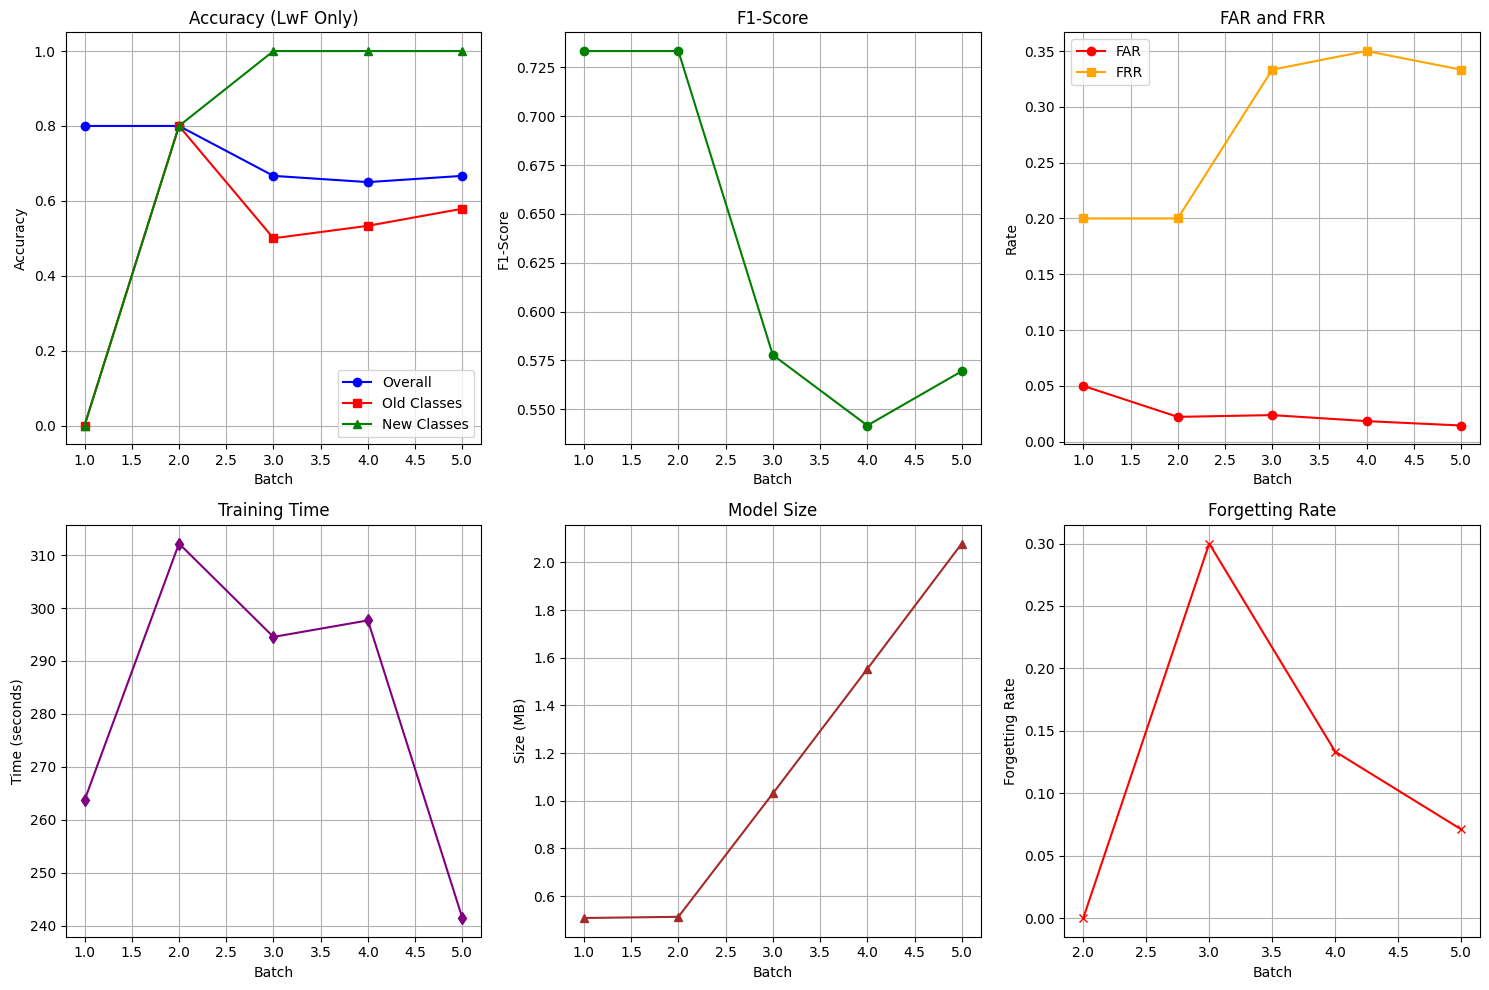


LwF-ONLY EXPERIMENT SUMMARY
Total persons trained: 24
Final overall accuracy: 0.6667
Final old class accuracy: 0.5789
Final new class accuracy: 1.0000
Avg training time per batch: 281.91s
Final model size: 2.08 MB
Final FAR: 0.0145
Final FRR: 0.3333
Final recall: 0.6667
Average confidence: 0.7433

Forgetting Analysis:
Average forgetting rate: 0.1261
LwF Performance: POOR - Consider enabling Joint Training

Files generated:
- lwf_only_results.csv
- lwf_only_results.png
- lwf_only_model_batch_*.pth

ANALYSIS GUIDE:
Compare these LwF-only results with your previous results to understand:
1. How much Joint Training contributed to performance
2. Whether LwF alone can prevent catastrophic forgetting
3. The computational efficiency vs performance trade-off

Experiment completed successfully!
Device used: cpu
LwF Temperature: 3.0
LwF Alpha: 0.5

INTERPRETATION:
Moderate accuracy - LwF provides some benefit

Now compare with your Joint Training + LwF results!


In [ ]:

# Run the experiment
if __name__ == "__main__":
    print("Face Recognition: Transfer Learning + LwF Only")
    print("Joint Training is DISABLED to isolate LwF contribution")
    print("="*60)

    # Install required packages first (run in separate cells if needed)
    """
    !pip install insightface
    !pip install onnxruntime
    !pip install torch torchvision
    !pip install opencv-python
    !pip install scikit-learn
    !pip install matplotlib pandas
    """

    # Run the clean LwF-only experiment
    results, researcher = main()

    print("\nANALYSIS GUIDE:")
    print("="*50)
    print("Compare these LwF-only results with your previous results to understand:")
    print("1. How much Joint Training contributed to performance")
    print("2. Whether LwF alone can prevent catastrophic forgetting")
    print("3. The computational efficiency vs performance trade-off")

    print(f"\nExperiment completed successfully!")
    print(f"Device used: {researcher.device}")
    print(f"LwF Temperature: {researcher.lwf_temperature}")
    print(f"LwF Alpha: {researcher.lwf_alpha}")

    # Expected outcomes
    print("\nINTERPRETATION:")
    if len(results) > 1:
        final_accuracy = results['accuracy'].iloc[-1]
        if final_accuracy > 0.8:
            print("High accuracy suggests LwF is working well")
        elif final_accuracy > 0.6:
            print("Moderate accuracy - LwF provides some benefit")
        else:
            print("Low accuracy - Joint Training may be crucial")

    print("\nNow compare with your Joint Training + LwF results!")